In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
import sys
print (sys.version_info)
path = os.path.dirname(os.__file__)
print(path)

sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
/Users/jianhaisu/opt/anaconda3/lib/python3.7


In [3]:
def triPlot(reordedScores, reordedCancerColMean, reordedClearColMean, featnames, dataTag,
            titleTag=None, ytickSize=16, xtickSize=16, titleSize=16, legendFontSize=16):
    numFeat = len(featnames)
    x = range(1, 1+numFeat)
    plt.figure(figsize=(20,10))
    plt.plot(x, reordedScores, 'b-*', label="Importance")
    plt.plot(x, reordedCancerColMean, 'r-o', label="Young-FeatureMean")
    plt.plot(x, reordedClearColMean, 'g-s', label="Old-FeatureMean")
    plt.legend(loc="best", fontsize=legendFontSize)
    plt.xticks(ticks=x, labels=featnames, rotation=90, fontsize=xtickSize)
    plt.yticks(fontsize=ytickSize)

    title = "{}: {} Features".format(dataTag, numFeat)
    if titleTag:
        title = title+"_"+titleTag
    plt.title(title, fontsize=titleSize)
    plt.grid()
    
    plt.tight_layout()
    filename = "impt_cancer_clear_{}_{}Features.png".format(dataTag, numFeat)
    plt.savefig(filename, dpi=600)

    
def selTriPlot(diffThreshold, imptScoreThreshold,
               reordedScores, reordedCancerColMean, reordedClearColMean, featnames,
               dataTag, ytickSize=16, xtickSize=16, titleSize=16, legendFontSize=16):
    diffIDs = np.where(diffFeatVals>diffThreshold)[0]+1
    diffIDs = diffIDs.tolist()
    scoreIDs = np.where(np.array(reordedScores)>imptScoreThreshold)[0]+1
    scoreIDs = scoreIDs.tolist()
    selection = list(set(diffIDs).intersection(set(scoreIDs)))
    list.sort(selection)
    
    numFeat = len(selection)
    selS = [reordedScores[i-1] for i in selection]
    selCancerM = [reordedCancerColMean[i-1] for i in selection]
    selClearM = [reordedClearColMean[i-1] for i in selection]
    selFN = [featnames[i-1] for i in selection]
    titleTag = "diffT{}_scoreT{}".format(diffThreshold, imptScoreThreshold)
    triPlot(selS, selCancerM, selClearM, selFN, dataTag, titleTag=titleTag,
            ytickSize=ytickSize, xtickSize=xtickSize, titleSize=titleSize, legendFontSize=legendFontSize)

    
def weightedDiffPlot(reordedScores, reordedCancerColMean, reordedClearColMean, featnames, dataTag, numFeat):
    x = range(1, 1+numFeat)
    diffFeatVals = np.abs(np.array(reordedCancerColMean) - np.array(reordedClearColMean))
    weightedDiffs = diffFeatVals*reordedScores
    plt.figure(figsize=(20,10))
    plt.plot(x, weightedDiffs, 'r-o', label="Weighted Abs Diff (Feature Mean)")
    plt.legend(loc="best", fontsize=16)
    plt.title("{}: {} Features".format(dataTag, numFeat), fontsize=16)
    plt.xticks(ticks=x, labels=featnames, rotation=90, fontsize=12)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.savefig("weighted_abs_feat_mean_diff_{}_{}Features.png".format(dataTag, numFeat), dpi=600)


In [4]:
featDirPre="extFeat_AgeGroup" 
dataTags = ["All"]
numFeats = [100]
 # 95
imptPost = "_importance.csv"
dataTag = "All"
numFeat = 100
featDir = featDirPre+"_"+dataTag
featFP     = os.path.join(featDir, str(numFeat)+"feats.csv")
featImptFP = os.path.join(featDir, str(numFeat)+"feats"+imptPost)

feats = pd.read_csv(featFP)
feats = feats.rename(columns={"class": "AgeGroup"})
YoungDF = feats.loc[(feats['AgeGroup'] == 1.0)].drop(columns=["AgeGroup"])
YoungDF = YoungDF.mean()
OldDF = feats.loc[(feats['AgeGroup'] == -1)].drop(columns=["AgeGroup"])
OldDF = OldDF.mean()
featsImpt = pd.read_csv(featImptFP)
numFeat = len(featsImpt.FeatureName)

In [5]:
labels = ["Young", "Old"]
labelColors = ["yellow","green"]
my_palette = dict(zip(feats.AgeGroup.unique(), labelColors))
row_colors = feats.AgeGroup.map(my_palette)
feats=feats.drop(columns=["AgeGroup"])

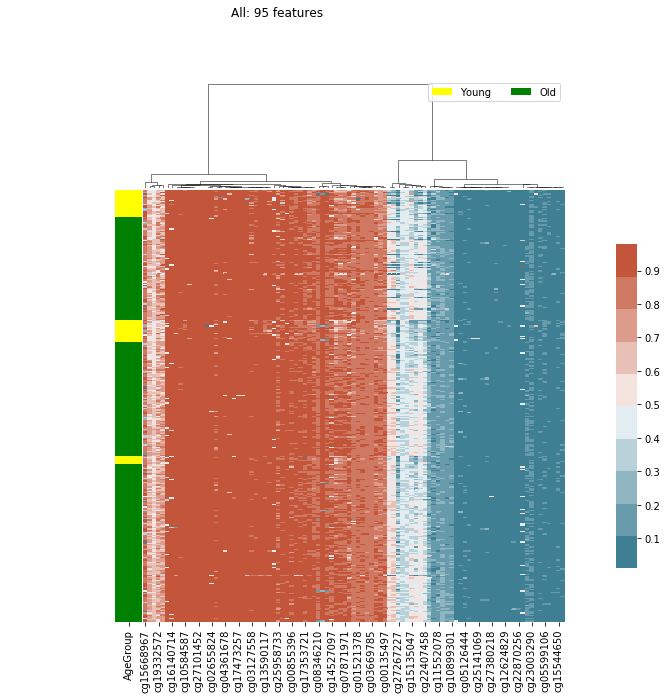

In [6]:
vmin = 0
vmax = 1
numCors = 10
interval = round((vmax-vmin)/numCors, 3)
corBarTicks = np.arange(vmin, vmax+interval, interval)
cmap = sns.diverging_palette(220, 20, n=numCors) # "viridis"
g = sns.clustermap(feats, metric="euclidean", method="ward",
                   cmap=cmap, cbar_kws={"ticks":corBarTicks},
                   robust=True, linewidths=0, row_colors=row_colors, yticklabels=False,
                   row_cluster=False
                  )#, xticklabels=False, yticklabels=False)
g.fig.suptitle("{}: {} features".format(dataTag, numFeat))


# Draw the legend bar for the classes                 
for label, labelColor in zip(labels, labelColors):
    g.ax_col_dendrogram.bar(0, 0, color=labelColor, label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="upper right", ncol=5)

# Adjust the postion of the main colorbar for the heatmap
g.cax.set_position([.97, .2, .03, .45])
g.savefig("clustermap_{}_{}Features.png".format(dataTag, numFeat), dpi=1200)

In [7]:
reorderIdx = g.dendrogram_col.reordered_ind
featnames = feats.columns
reorderedFeatnames = [str(fID)+":"+featnames[idx] for fID, idx in zip(range(1,1+numFeat), reorderIdx)]
reorderedFeatnames_csv = [featnames[idx] for fID, idx in zip(range(1,1+numFeat), reorderIdx)]
scores = featsImpt.Importance_Score
reordedScores = [scores[idx] for idx in reorderIdx]
youngColMean = YoungDF.to_numpy()
reordedYoungColMean = [youngColMean[idx] for idx in reorderIdx]
oldColMean = OldDF.to_numpy()
reordedOldColMean = [oldColMean[idx] for idx in reorderIdx]
diffFeatVals = np.abs(np.array(reordedYoungColMean) - np.array(reordedOldColMean))

dumpData = np.array([[s, d, ca, ce] for s, d, ca, ce in 
                     zip(reordedScores,diffFeatVals, reordedYoungColMean, reordedOldColMean)
                    ])
dumpDF = pd.DataFrame(
    data=dumpData,
    columns=["Importance Score", "Difference", "Young", "Old"], 
    index=reorderedFeatnames_csv)
dumpDF.to_csv("Mean_Value_of_Each_HSIC_Lasso_Selected_Features_{}AgeGroup_AgeDetection.csv".format(dataTag))

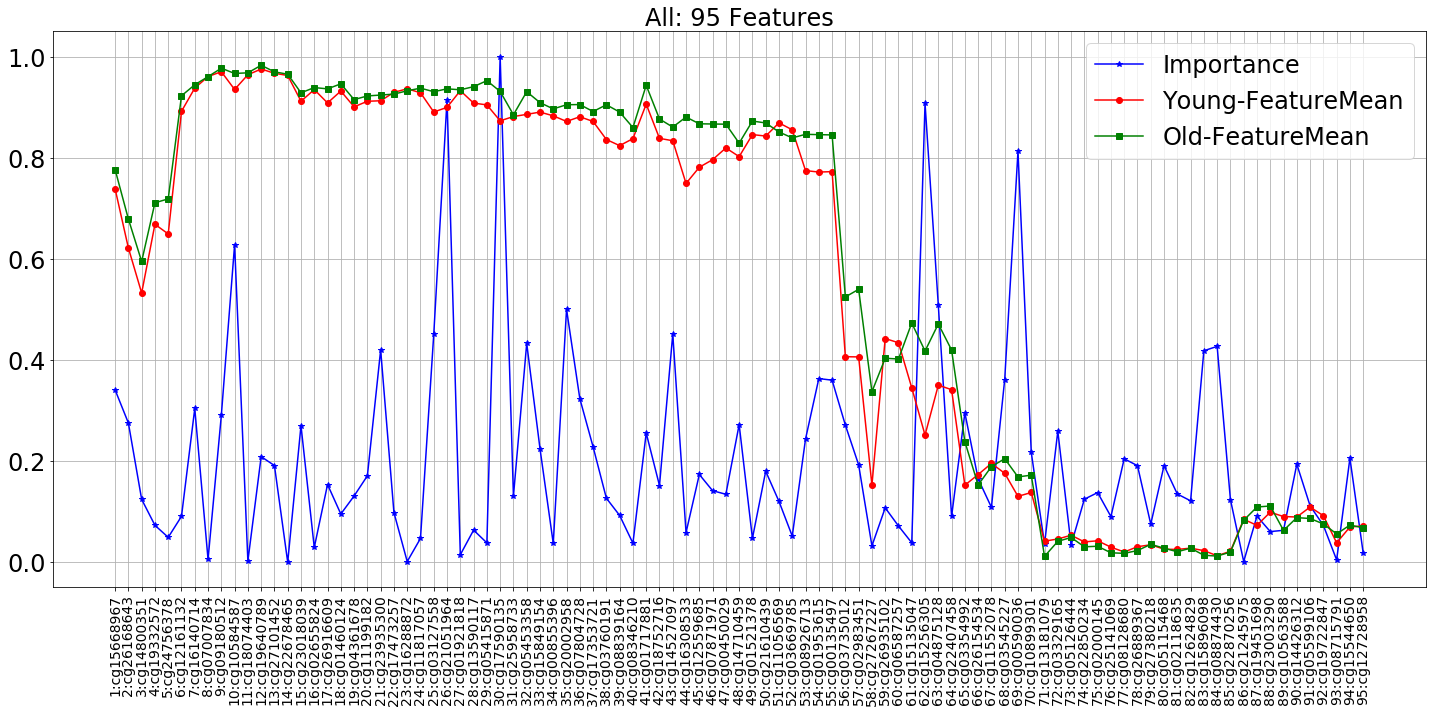

In [8]:
triPlot(reordedScores, reordedYoungColMean, reordedOldColMean, reorderedFeatnames, dataTag,
       ytickSize=24, xtickSize=14, titleSize=24, legendFontSize=24)

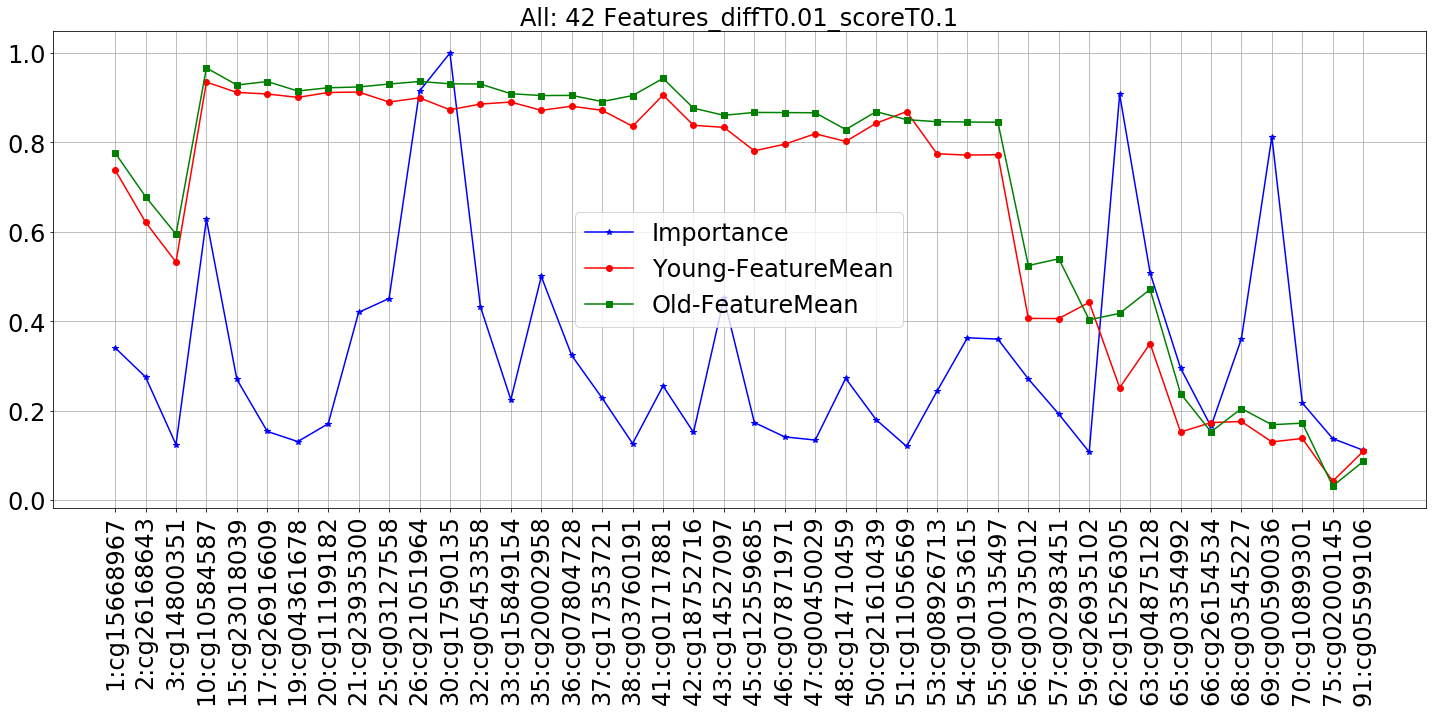

In [9]:
diffThreshold = 0.01
imptScoreThreshold = 0.1

selTriPlot(diffThreshold, imptScoreThreshold,
           reordedScores, reordedYoungColMean, reordedOldColMean, reorderedFeatnames,
           dataTag, ytickSize=24, xtickSize=24, titleSize=24, legendFontSize=24)

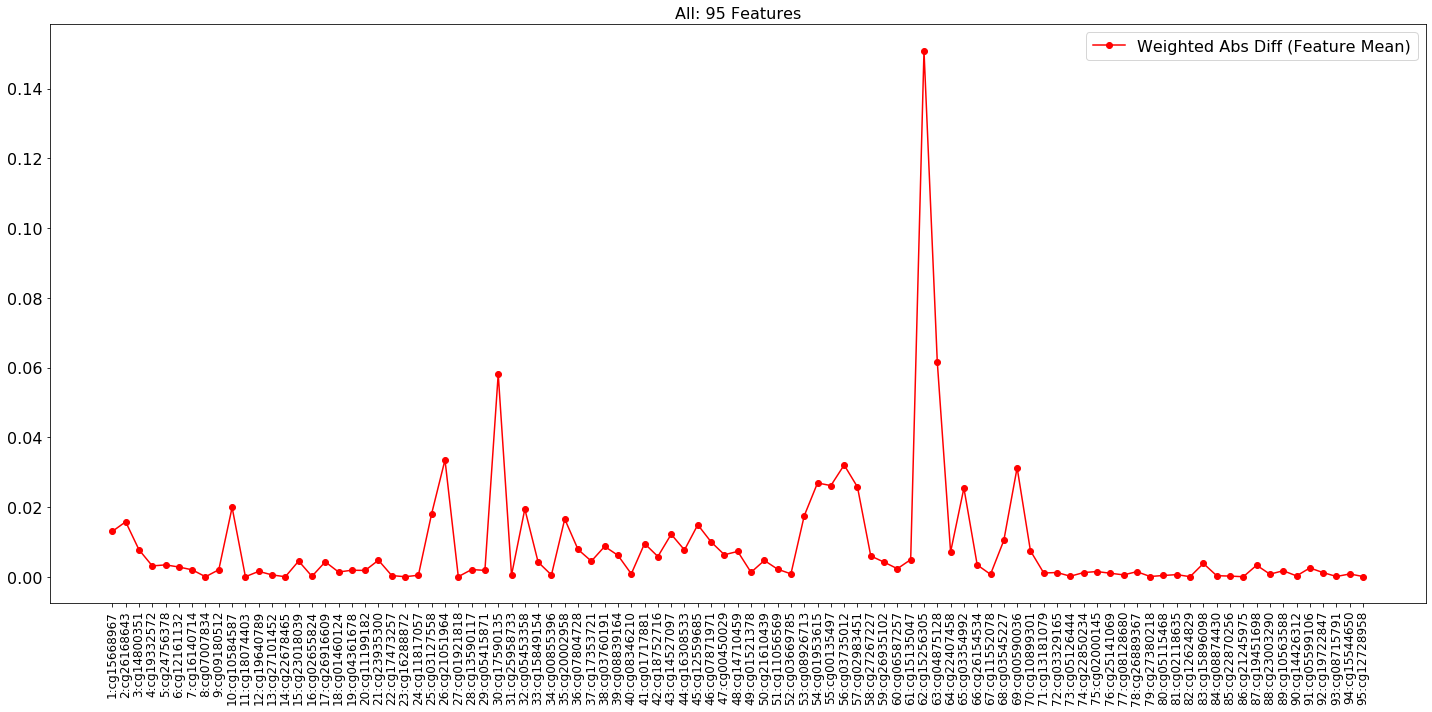

In [13]:
weightedDiffPlot(reordedScores, reordedYoungColMean, reordedOldColMean, reorderedFeatnames, dataTag, numFeat)

In [36]:
model_result_dir = "result_AgeGroup_All_WeightEqual"
test_Acc_filename = "AgeGroup_SVM_12FeatureGroups_40TestRatio_50BOIters_Accs.csv"
test_Acc_fp = os.path.join(model_result_dir, test_Acc_filename)
accs = pd.read_csv(test_Acc_fp)
accs

,NumFeatures,TrainAcc,TestAcc
0,5,0.870,0.8657
1,10,0.935,0.9104
2,30,0.965,0.9179
3,50,0.990,0.8955
4,70,0.995,0.9104
5,100,0.985,0.9478
6,150,0.985,0.9478
7,200,0.990,0.9552
8,400,0.990,0.9552
9,600,0.985,0.9478


In [37]:
accs = accs.head(5)
row_df = pd.DataFrame(
    data = np.array([[95, 0.990, 0.9552]]),
    columns=["NumFeatures", "TrainAcc", "TestAcc"])
accs = accs.append(row_df, ignore_index=True)
accs

,NumFeatures,TrainAcc,TestAcc
0,5.0,0.870,0.8657
1,10.0,0.935,0.9104
2,30.0,0.965,0.9179
3,50.0,0.990,0.8955
4,70.0,0.995,0.9104
5,95.0,0.990,0.9552


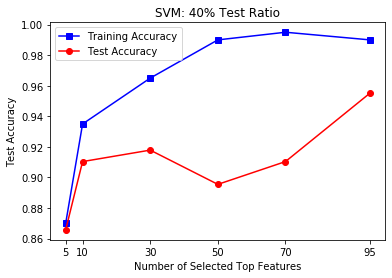

In [34]:
numFeats = accs.NumFeatures.to_numpy()
numFeats = [int(num) for num in numFeats]
trainAcc = accs.TrainAcc.to_numpy()
testAcc = accs.TestAcc.to_numpy()
clf_name = "SVM"
test_ratio = 0.4
itersBO = 50
resultFDName="./"

plt.figure(127)
plt.plot(numFeats, trainAcc, 'b-s', label="Training Accuracy")
plt.plot(numFeats, testAcc, 'r-o', label="Test Accuracy")
plt.legend(loc="best")
plt.title("{}: {}% Test Ratio".format(clf_name, int(100*test_ratio)))
plt.xlabel("Number of Selected Top Features")
plt.ylabel("Test Accuracy")
plt.xticks(numFeats)
figFP = os.path.join(
    resultFDName,
    "{}_{}FeatureGroups_{}TestRatio_{}BOIters_Accs.png".format(
        clf_name, len(numFeats), int(100*test_ratio), itersBO)
)
plt.savefig(figFP, dpi=600)